##### This notebook accesses the ERA5 moisture budget components for the AR sector given. From this, it plots the horizontal field data of the AR corridor,  and specifies the mean values inside the prefrontal sectors given. 

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: Henning Dorff
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3budget_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3budget_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")


###############################################################################
#import flightcampaign
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [16]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
ar_of_day="AR_entire_1"
flight=["RF06"]
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
flight=cmpgn_cls.flight
#radar

In [17]:
Dropsondes.keys()

if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)

In [18]:
import interpdata_plotting
from flightmapping import FlightMaps
        
#-------------- Plot Path Specifications ---------------------------------#
major_plot_path=cmpgn_cls.campaign_path+"/plots/"
if not os.path.exists(major_plot_path):
    os.mkdir(major_plot_path)
plot_path=major_plot_path+flight[0]+"/"
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

#Check if plot path exists, if not create it.
if ar_of_day!=None:
        plot_path=plot_path+ar_of_day+"/"
        if not os.path.exists(plot_path):
            os.mkdir(plot_path)
    #-------------------------------------------------------------------------#
ERA_HALO_Plotting   = interpdata_plotting.ERA_HALO_Plotting(
                                        flight,ar_of_day=ar_of_day,
                                        plot_path=plot_path,
                                        synthetic_campaign=False)    
#CARRA_HALO_Plotting = interpdata_plotting.CARRA_HALO_Plotting(
#                                        plot_path=plot_path,
#                                        flight=flight,ar_of_day=ar_of_day,
#                                        synthetic_campaign=synthetic_flight)
#-------------------------------------------------------------------------#
#Load Flight map class
Flightmap=FlightMaps(cmpgn_cls.major_path,cmpgn_cls.campaign_path,
                         cmpgn_cls.aircraft,cmpgn_cls.instruments,
                         cmpgn_cls.interested_flights,plot_path=plot_path,
                         flight=flight[0],ar_of_day=ar_of_day,
                         synthetic_campaign=False,
                         synthetic_icon_lat=0,
                         synthetic_icon_lon=0,
                         track_type="internal",pick_legs="all",
                         track_dict=None)

set_font=ERA_HALO_Plotting.specify_plotting()
style_name="typhon"


IVT conv. mapped
Evaporation mapped
Total precipitation mapped
IWV Tendency mapped
Hour of the day: 12
Meridional-Zonal ratio:  -5.814734803146581
PLot path  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/plots/RF06/AR_entire_1/
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/plots/RF06/AR_entire_1/AR_entire_1_HALO_AC3_RF06_Moisture_Components_Map_ERA5.png


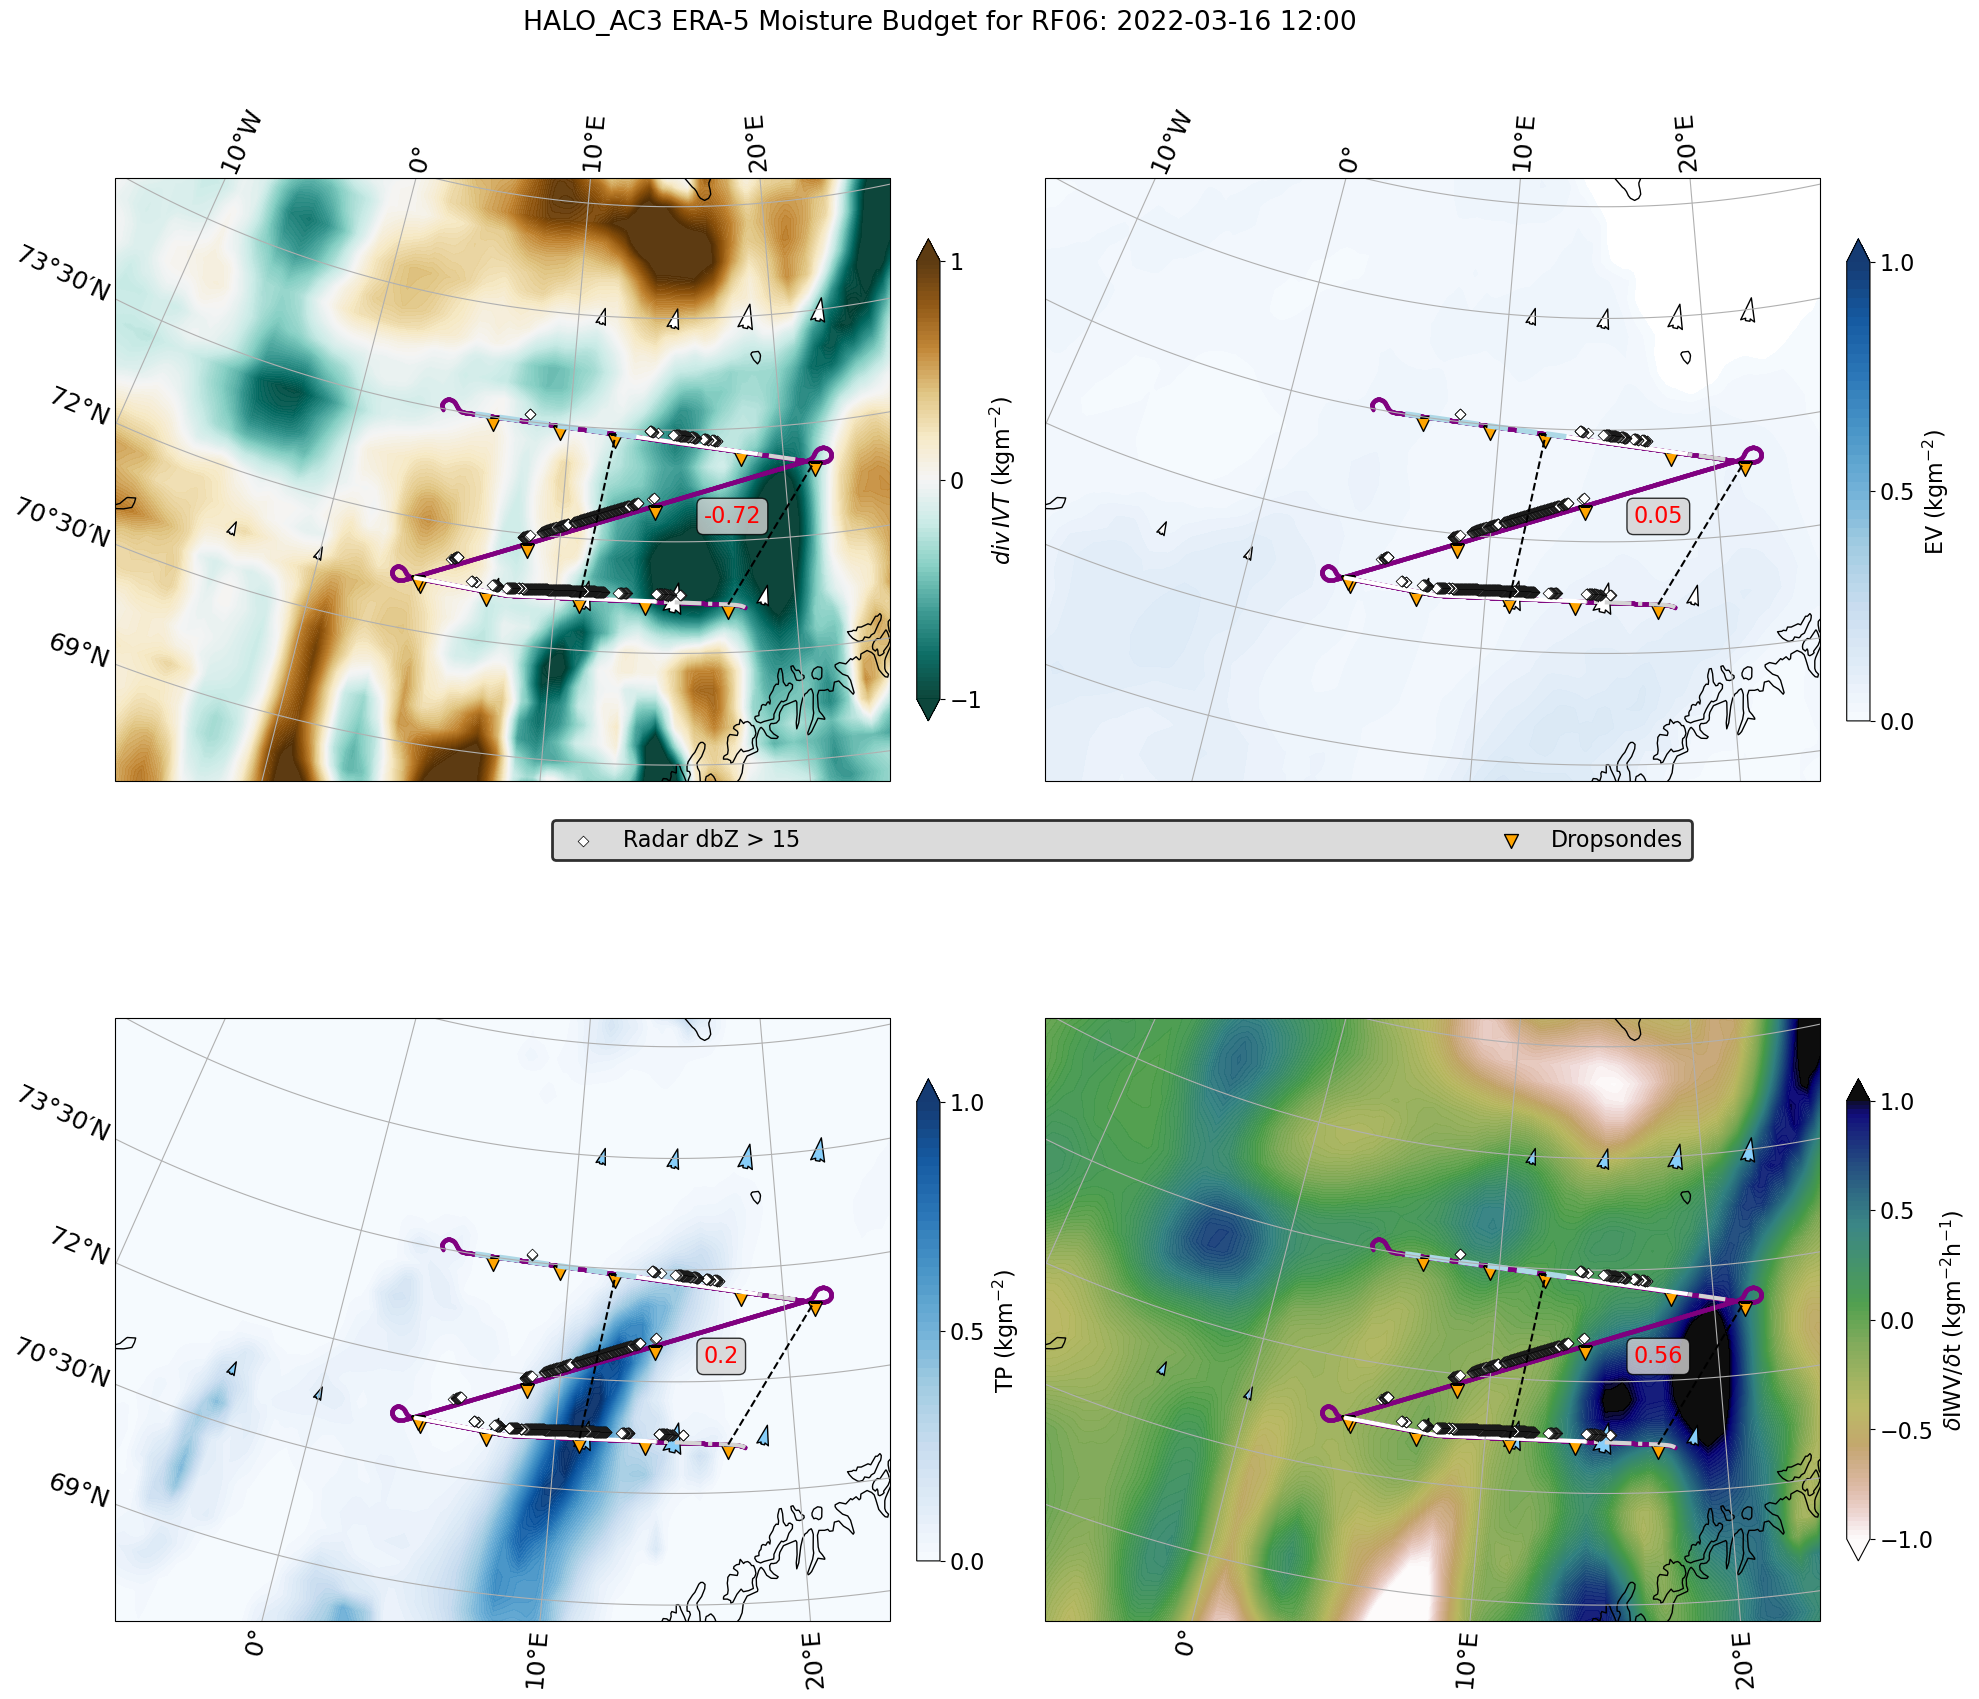

In [19]:
# Map the AR flight intersection
last_hour=pd.DatetimeIndex(halo_df.index).hour[-1]#
Flightmap.halo_dict={flight[0]:halo_df}

Flightmap.plot_AR_moisture_components_map(ERA5_on_HALO,radar,Dropsondes,cmpgn_cls,
                                          do_sector_based=True,only_warm_sector=True)
halo_era5.name="ERA5"

In [7]:
""" OLD """
#hmc_plotting_desired=False
#if hmc_plotting_desired:
#    # ERA5 
#    if era_is_desired:
#           halo_era5_hmc=ERA5_on_HALO.load_hwc()
#       #----------------------------------------------------------------------#
#       # CARRA
#    if not carra_is_desired:
#           pass
#    else:
#        CARRA_on_HALO.load_or_calc_interpolated_hmc_data()
#        halo_carra_hmc=CARRA_on_HALO.carra_halo_hmc
#    #
#    # ICON                                                               
#    if not icon_is_desired:
#            pass
#    else:
#        #Get vertical profiles of moisture/ hydrometeors
#        halo_icon_hmc=ICON_on_HALO.load_hwc(with_hydrometeors=False)
#    #----------------------------------------------------------------------#    
#    # Retrieval
#    if flight==["RF10"]:
#        if include_retrieval:
#            retrieval_dict=cmpgn_cls.load_radiometer_retrieval(
#                                       campaign,
#                                       variables=["T","rho_v"],
#                                       calculate_spec_hum=True,
#                                       sonde_p=Upsampled_Dropsondes["Pres"])
#            retrieval_dict=cmpgn_cls.vertical_integral_retrieval(
#                                        retrieval_dict,Upsampled_Dropsondes)
#                
#
#    """
#        Plotting of datasets from HALO_ERA_Plotting class   
#    """
#    levels=np.linspace(0,50,50)

' OLD '